### Data Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

We read in our rotten tomatoes csv and select only the columns with the information we have deemed to be critical to our machine learning algorithm.

In [2]:
movies = pd.read_csv('data/rotten_tomatoes_movies.csv')
critical_columns = ['movie_title', 'content_rating', 'genres', 'directors', 'runtime', 'tomatometer_status', 
                    'tomatometer_rating', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
                    'tomatometer_rotten_critics_count', 'original_release_date']
movies = movies[critical_columns]
movies.head()

,movie_title,content_rating,genres,directors,runtime,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,original_release_date
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,119.0,Rotten,49.0,43,73,76,2010-02-12
1,Please Give,R,Comedy,Nicole Holofcener,90.0,Certified-Fresh,87.0,44,123,19,2010-04-30
2,10,R,"Comedy, Romance",Blake Edwards,122.0,Fresh,67.0,2,16,8,1979-10-05
3,12 Angry Men (Twelve Angry Men),NR,"Classics, Drama",Sidney Lumet,95.0,Certified-Fresh,100.0,6,54,0,1957-04-13
4,"20,000 Leagues Under The Sea",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,127.0,Fresh,89.0,5,24,3,1954-01-01


We know that the genre of the movie will be an important predictor, so we collect all the different genres into a set so we can see the unique values. 

In [3]:
genre_set = set()
for i in movies['genres']:
    if (type(i) == str):
        for j in i.split(','):
            j = j.strip()
            genre_set.add(j)
print(genre_set)

{'Documentary', 'Cult Movies', 'Horror', 'Kids & Family', 'Science Fiction & Fantasy', 'Special Interest', 'Classics', 'Anime & Manga', 'Sports & Fitness', 'Mystery & Suspense', 'Western', 'Romance', 'Comedy', 'Action & Adventure', 'Faith & Spirituality', 'Gay & Lesbian', 'Animation', 'Drama', 'Musical & Performing Arts', 'Art House & International', 'Television'}


We are interested in how many null values are in our csv because they can cause errors in our machine learning algorithms. We look through the columns and see how many null values they all have.

In [4]:
for i in movies.columns:
    print(i,movies[i].isnull().values.sum())

movie_title 0
content_rating 0
genres 19
directors 194
runtime 314
tomatometer_status 44
tomatometer_rating 44
tomatometer_top_critics_count 0
tomatometer_fresh_critics_count 0
tomatometer_rotten_critics_count 0
original_release_date 1166


Since there aren't very many null values across our columns, we will just drop all the null values to avoid any problems later on. 

In [5]:
movies = movies.dropna()
movies.shape

(16208, 11)

Genres list is a categorigal variable with no order. So we one hot encoded it.
To one hot encode the genres, first made genres into a new genres list. Then, applied Series to each 'genres list' element

In [6]:
movies['genres list'] = movies['genres'].str.split(', ', expand=False)
genres_series = movies['genres list'].apply(pd.Series).stack()
genres_encoded = pd.get_dummies(genres_series).groupby(level=0).sum()
# movies = pd.concat([movies, genres_encoded], axis=1)

genres_list = []
for i in genres_encoded.index:
    row_list = genres_encoded.loc[i, :].values.flatten().tolist()
    genres_list.append(row_list)

movies['genres_encoded'] = genres_list

movies['content_rating'].value_counts()

R        6092
NR       4507
PG-13    2863
PG       2067
G         644
NC17       35
Name: content_rating, dtype: int64

Ratings have an order to it, so we turned it into an ordinal numerical value.

In [7]:
ratings = {'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3, 'NC17': 4, 'NR': 5}

movies['content_rating_id'] = movies['content_rating'].map(ratings)

We turned original release date into a pandas date time object so we can easily compare it to each other

In [8]:
movies['original_release_date'] = pd.to_datetime(movies['original_release_date'])

In [9]:
#reordering the columns
reordered_columns = ['movie_title', 'content_rating', 'content_rating_id', 'genres', 'genres_encoded', 'directors',
                    'runtime', 'original_release_date', 'tomatometer_status', 'tomatometer_rating', 
                    'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']
movies = movies[reordered_columns]
movies.head()

,movie_title,content_rating,content_rating_id,genres,genres_encoded,directors,runtime,original_release_date,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,Percy Jackson & the Olympians: The Lightning T...,PG,1,"Action & Adventure, Comedy, Drama, Science Fic...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Chris Columbus,119.0,2010-02-12,Rotten,49.0,43,73,76
1,Please Give,R,3,Comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Nicole Holofcener,90.0,2010-04-30,Certified-Fresh,87.0,44,123,19
2,10,R,3,"Comedy, Romance","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Blake Edwards,122.0,1979-10-05,Fresh,67.0,2,16,8
3,12 Angry Men (Twelve Angry Men),NR,5,"Classics, Drama","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Sidney Lumet,95.0,1957-04-13,Certified-Fresh,100.0,6,54,0
4,"20,000 Leagues Under The Sea",G,0,"Action & Adventure, Drama, Kids & Family","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",Richard Fleischer,127.0,1954-01-01,Fresh,89.0,5,24,3


In [42]:
movies.shape

(16208, 13)

In [11]:
movies.to_csv('data/rotten_tomatoes_movies_clean.csv', index=False)

In [56]:
movies_clean = pd.read_csv('data/rotten_tomatoes_movies_clean.csv')
movies_clean['original_release_date'] = pd.to_datetime(movies_clean['original_release_date'])

In [57]:
def genres_encoded_fix(val):
    lst = [int(i) for i in val if i == '1' or i == '0']
    return lst

movies_clean['genres_encoded'] = movies_clean['genres_encoded'].apply(genres_encoded_fix);

### Data Visualizations

First we do a heatmap to get an idea of possible correlations between variables. 

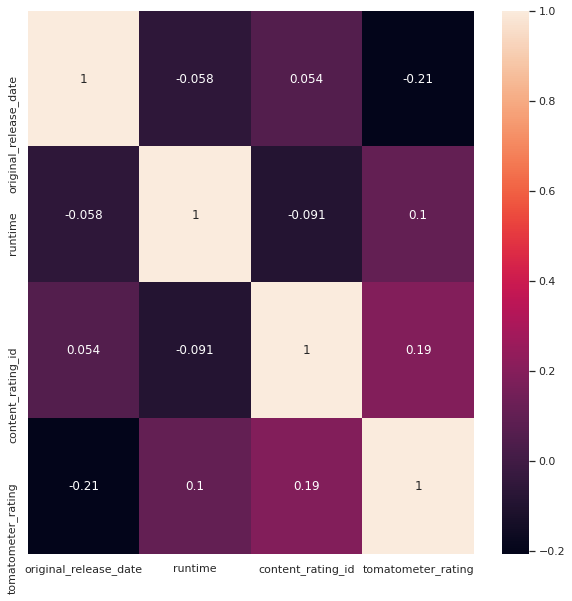

In [58]:
selected_columns = ['original_release_date', 'runtime', 'content_rating_id', 'tomatometer_rating']
movies_corr = movies_clean.loc[:,selected_columns].corr(numeric_only=False)
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(movies_corr, annot = True);

From this heatmap we can see that there is a slight negative correlation (-0.21) which tells us that there is some truth to the idea that critics give higher ratings to older movies and lower ratings to newer ones. 

There is also a slight positive correlation (0.14) between the content rating of a movie and the critic ratings which would hint at movies with a more adult content rating receiving higher reviews than movies targeted towards kids. 

Next we figure out the percentage of each genre of movie that are given Fresh or Certified-Fresh reviews in order to see which genres are highest and lowest rated. 

In [59]:
genres_dict = {}
for i in range(len(genre_set)):
    genres_dict[i] = [0,0]
    
for index in movies_clean.index:
    genres_enc = movies_clean.loc[index,'genres_encoded']
    tomato = movies_clean.loc[index,'tomatometer_status']
    for i in range(len(genres_enc)):
        if genres_enc[i] == 1:
            if tomato == 'Fresh' or tomato == 'Certified-Fresh':
                genres_dict[i][0] += 1
            else:
                genres_dict[i][1] += 1

        
print(genres_dict)

{0: [1545, 1753], 1: [317, 219], 2: [15, 3], 3: [1703, 614], 4: [1331, 258], 5: [2532, 2734], 6: [56, 42], 7: [1574, 221], 8: [5410, 3532], 9: [43, 28], 10: [34, 38], 11: [776, 1040], 12: [496, 529], 13: [669, 262], 14: [1588, 1702], 15: [1012, 804], 16: [844, 884], 17: [956, 195], 18: [122, 43], 19: [159, 52], 20: [184, 105]}


In [61]:
movies_to_tomato = {}
for i in genres_dict:
    movies_to_tomato[genres_encoded.columns[i]] = genres_dict[i][0]/float(genres_dict[i][0]+genres_dict[i][1])

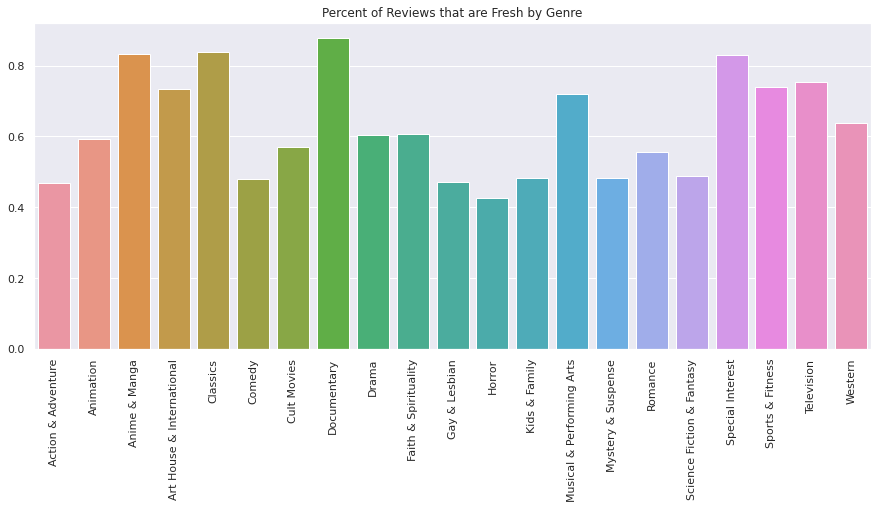

In [62]:
keys = list(movies_to_tomato.keys())
vals = [float(movies_to_tomato[k]) for k in keys]

sns.set(rc={"figure.figsize":(15, 6)})
plot = sns.barplot(x=keys, y=vals)
plot.set_title("Percent of Reviews that are Fresh by Genre")
plot.set_xticklabels(labels = keys,rotation=90);

From this bar graph we can see that some genres receive higher ratings than others. For example, Documentaries, Classics, Anime & Manga, and Special Interest movies are much more likely to receive positive reviews than a genre like Horror, so we would expect our Machine Learning algorithm to predict higher ratings for those genres on average than for Horror movies. 

Lastly we wanted to look at the runtime of movies compared with the rating the movie received. 

In [ ]:
sns.set(rc={"figure.figsize":(15, 6)})
plot = sns.kdeplot(x=movies_clean['runtime'], y=movies_clean['tomatometer_rating'])
plot.set_title("Distribution of Movie Ratings and Runtime")

We see that most movies end up being around 90 minutes long. There seems to be a very slight trend towards a higher rating with movies between 110-150 minutes long, but overall there is a very slight positive correlation between runtime and rating. 